In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 124 (delta 38), reused 42 (delta 21), pack-reused 55
Receiving objects: 100% (124/124), 191.92 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
cd lag-llama

/content/lag-llama/lag-llama/lag-llama


In [ ]:
!pip install -r requirements.txt --quiet # this could take some time # ignore the errors displayed by colab

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
/content/lag-llama/lag-llama.ckpt


In [ ]:
!pip install lightning

In [ ]:
from itertools import islice
import lightning

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("/content/lag-llama/lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="/content/lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [ ]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url = (
    "/content/drive/MyDrive/IITGN/Raw_data_1Hr_2023_site_1424_Jawaharlal_Nehru_Stadium_Delhi_DPCC_1Hr.csv"
)
columns = pd.read_csv(url, nrows=0).columns
selected_columns = columns[:6]
df_wide = pd.read_csv(url, usecols=selected_columns, index_col=0, parse_dates=True)
df_wide=df_wide.tail(192)

In [ ]:
# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

backtest_dataset = ds
prediction_length = 24  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

### Get predictions

We perform zero-shot inference.

In [ ]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

`forecasts` is a list of size `num_series` where `num_series` is the number of time series in your dataset. The samples can be accessed with the `.samples` object from each forecast.

`tss` is the ground truth time series, which is useful to visualize when plotting. You can ignore it otherwise.

In [ ]:
len(forecasts)

5

In [ ]:
forecasts[0].samples.shape

(100, 24)

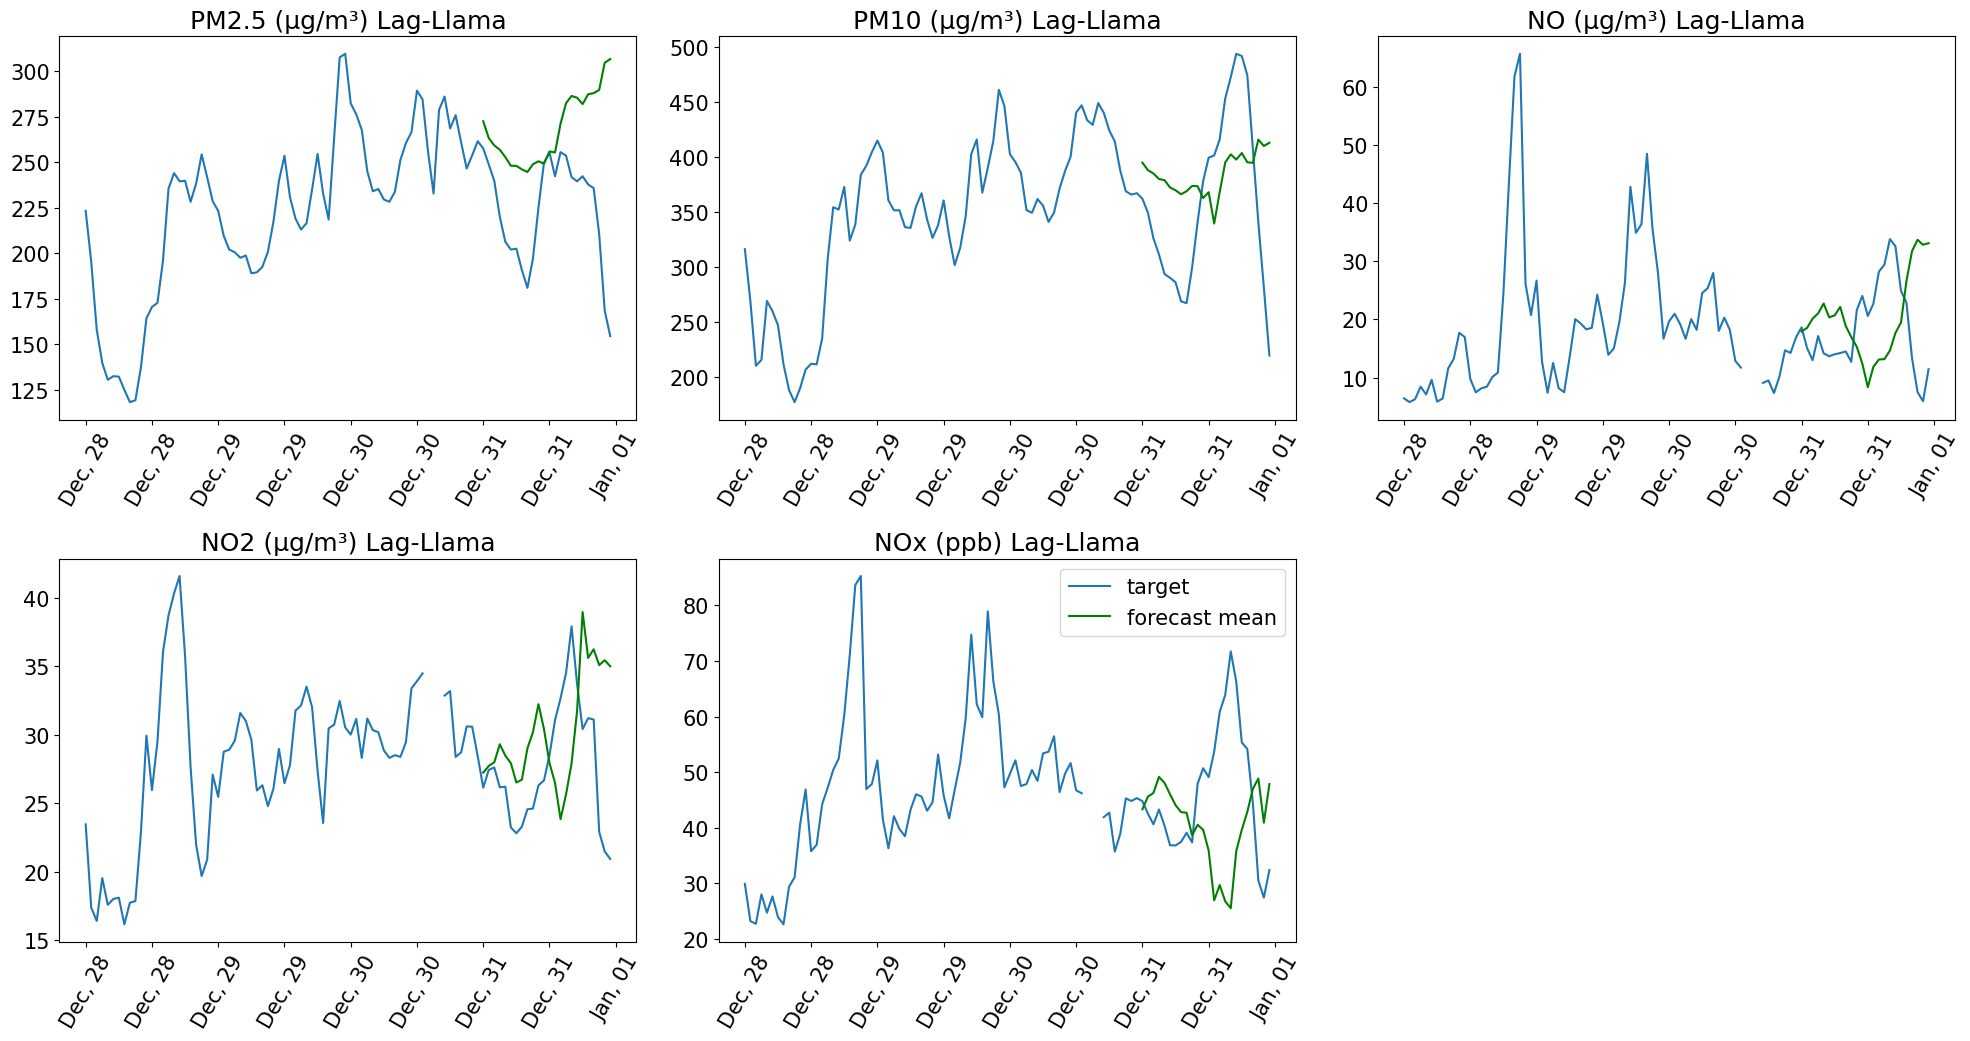

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})


for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 5):
    ax = plt.subplot(3, 3, idx+1)

    # Convert the last 4*prediction_length of the time series to timestamps and plot
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")

    # Extract and plot the mean forecast values
    forecast_dates = forecast.index.to_timestamp()  # Convert forecast index to timestamps
    plt.plot(forecast_dates, forecast.mean, color='g', label='forecast mean')

    # Setting up the plot
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id + " Lag-Llama")

plt.gcf().tight_layout()
plt.legend()
plt.show()


In [ ]:
import numpy as np

def calculate_metrics(forecasts, tss, prediction_length):
    # Initialize lists to store individual errors
    mae_errors = []
    mse_errors = []
    rmse_errors = []
    mape_errors = []

    for forecast, ts in zip(forecasts, tss):
        # Extract the relevant actual values for the prediction period
        actual = ts[-prediction_length:].values

        # Extract forecast mean values
        predicted = forecast.mean

        # Ensure that the actual and predicted arrays have the same length
        if len(actual) == len(predicted):
            # Calculate errors
            mae = np.mean(np.abs(actual - predicted))
            mse = np.mean(np.square(actual - predicted))
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100

            # Append errors to lists
            mae_errors.append(mae)
            mse_errors.append(mse)
            rmse_errors.append(rmse)
            mape_errors.append(mape)

    # Calculate average errors across all forecasts
    avg_mae = np.mean(mae_errors)
    avg_mse = np.mean(mse_errors)
    avg_rmse = np.mean(rmse_errors)
    avg_mape = np.mean(mape_errors)

    return avg_mae, avg_mse, avg_rmse, avg_mape

# Assuming forecasts and tss are lists of forecast and actual values respectively
avg_mae, avg_mse, avg_rmse, avg_mape = calculate_metrics(forecasts, tss, prediction_length)

print(f"Mean Absolute Error (MAE): {avg_mae}")
print(f"Mean Squared Error (MSE): {avg_mse}")
print(f"Root Mean Squared Error (RMSE): {avg_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {avg_mape}%")


Mean Absolute Error (MAE): 28.377090454101562
Mean Squared Error (MSE): 2099.52783203125
Root Mean Squared Error (RMSE): 34.193458557128906
Mean Absolute Percentage Error (MAPE): 28.730775117874146%
